,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.73,3454.92,10829.17,5737.48,4333.81,0.00,6392.95,39254.05,73010.41
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50,5091.71,11588.19,8659.56,6217.46,6147.83,7422.08,57194.33,73010.41
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50,7460.20,12361.78,11581.63,7075.66,15824.69,9769.56,76141.03,73010.41
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15,9952.24,13452.19,14503.71,9134.36,18802.19,13101.70,94203.53,73010.41
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15,12182.21,13744.60,17425.79,9942.36,18802.19,13469.22,100823.52,73010.41


,Значение
Количество записей,31430
Количество признаков,15
Пропущенные значения,10
Размер набора данных в памяти,10842.05 KB


,case_id,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
count,31430.00,31430.00,31430.00,31430.00,31430.00,31430.00,31430.00,31430.00,31430.00,31420.00
mean,1589.31,11073.67,8287.50,13593.86,13394.03,7015.32,9879.58,7657.71,70901.68,68316.00
std,917.22,4165.61,3271.14,1640.46,5204.55,2397.42,6778.22,3339.80,21846.55,16886.97
min,1.00,4209.31,2220.28,2216.46,3476.38,2611.64,0.00,1027.80,30087.66,25529.98
25%,792.00,8580.00,5801.42,12535.16,9667.44,5286.35,5341.62,5597.97,53776.02,57223.99
50%,1593.00,10416.00,8129.16,13698.16,13082.70,6733.06,10166.34,6898.47,70977.68,65955.61
75%,2386.00,12444.00,10703.62,14765.76,16657.82,8413.09,14276.38,8790.21,85371.34,76136.07
max,3171.00,61735.59,31178.62,19816.48,37252.27,28829.44,48831.09,47753.39,223717.55,177662.47


<ipython-input-2-9eea30cac44d>:158: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: x.sample(frac=.33))


,random_samples_mean,stratified_samples_mean
housing_cost,11079.57,11096.24
food_cost,8271.38,8294.43


,ci_mean 99.0%,ci_mean 95.0%,ci_mean 90.0%
housing_cost,"(11013.15, 11134.20)","(11027.62, 11119.73)","(11035.02, 11112.32)"
food_cost,"(8239.98, 8335.03)","(8251.34, 8323.67)","(8257.15, 8317.85)"


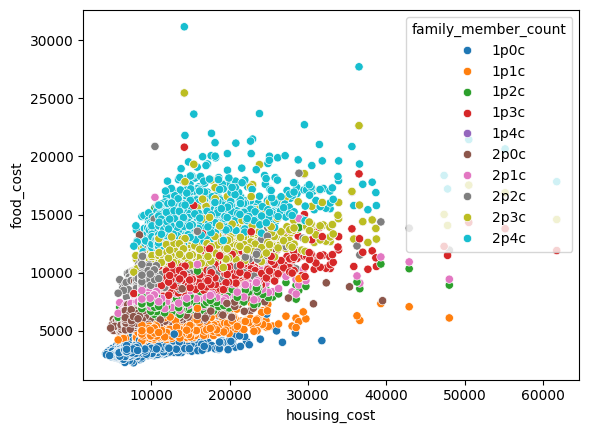

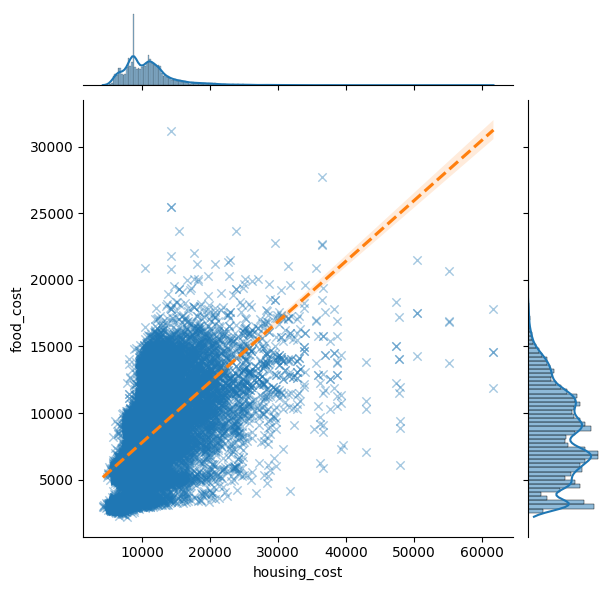

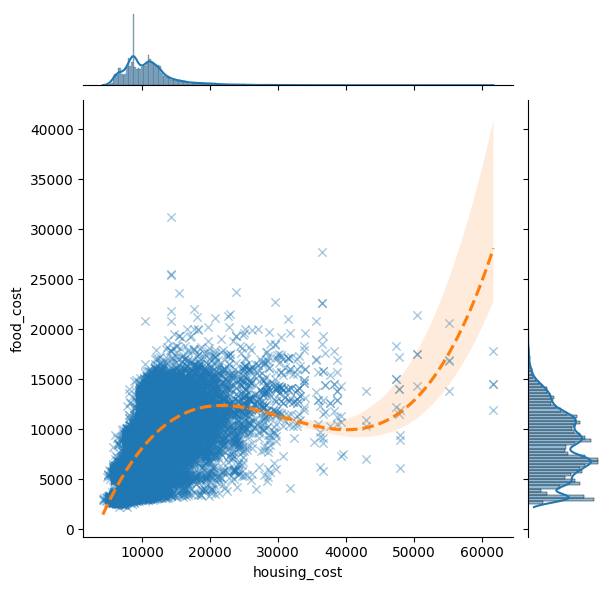

In [2]:
from typing import Tuple, List, Dict, Any

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

df = pd.read_csv('/content/cost_of_living_us.csv')

class CostOfLivingAnalyzer:
    """
    Description:
        Класс для анализа данных о стоимости жизни в США.
        Включает методы для визуализации, регрессионного анализа
        и расчета доверительных интервалов.

    Args:
        data_path: Путь к CSV файлу с данными
        random_state: Seed для воспроизводимости результатов

    Raises:
        FileNotFoundError: Если файл с данными не найден
        ValueError: Если данные содержат некорректные значения
    """

    def __init__(self, data_path: str, random_state: int = 1) -> None:
        """
        Description:
            Инициализация анализатора данных.

        Args:
            data_path: Путь к CSV файлу
            random_state: Зерно для генератора случайных чисел
        """
        self.random_state = random_state
        self.df = pd.read_csv(data_path)
        self._validate_data()

    def _validate_data(self) -> None:
        """
        Description:
            Проверка корректности загруженных данных.

        Raises:
            ValueError: Если отсутствуют необходимые столбцы или есть некорректные значения
        """
        required_columns = ['housing_cost', 'food_cost', 'family_member_count']
        if not all(col in self.df.columns for col in required_columns):
            raise ValueError("Отсутствуют необходимые столбцы в данных")

    def calculate_correlation(self) -> float:
        """
        Description:
            Расчет корреляции между стоимостью жилья и еды.

        Returns:
            Коэффициент корреляции Пирсона
        """
        return self.df['housing_cost'].corr(df['food_cost'])

    def create_scatter_plots(self) -> None:
        """
        Description:
            Создание визуализаций взаимосвязи между стоимостью жилья и еды.
        """
        # Базовый scatter plot
        sns.scatterplot(
            data=self.df,
            x='housing_cost',
            y='food_cost',
            hue='family_member_count',
            palette=sns.color_palette('tab10')
        )

        # Joint plot с линейной регрессией
        self._create_joint_plot(order=1)

        # Joint plot с полиномиальной регрессией
        self._create_joint_plot(order=3)

    def _create_joint_plot(self, order: int) -> None:
        """
        Description:
            Создание joint plot с регрессией заданного порядка.

        Args:
            order: Порядок полинома для регрессии
        """
        sns.jointplot(
            data=self.df,
            x='housing_cost',
            y='food_cost',
            kind='reg',
            ci=95,
            order=order,
            marker='x',
            line_kws={'color': 'C1', 'linestyle': 'dashed'},
            scatter_kws={'linewidths': 1., 'color': 'C0', 'alpha': .4}
        )

    def perform_regression_analysis(self) -> Tuple[float, float]:
        """
        Description:
            Выполнение линейного и полиномиального регрессионного анализа.

        Returns:
            Tuple с R² для линейной и полиномиальной регрессии
        """
        # Подготовка данных
        housing_cost = self.df['housing_cost'].to_numpy().reshape(-1, 1)
        food_cost = self.df['food_cost'].to_numpy()

        # Линейная регрессия
        linear_model = LinearRegression()
        linear_model.fit(housing_cost, food_cost)
        linear_pred = linear_model.predict(housing_cost)
        r2_linear = r2_score(food_cost, linear_pred)

        # Полиномиальная регрессия
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        housing_cost_poly = poly_features.fit_transform(housing_cost)
        poly_model = LinearRegression()
        poly_model.fit(housing_cost_poly, food_cost)
        poly_pred = poly_model.predict(housing_cost_poly)
        r2_poly = r2_score(food_cost, poly_pred)

        return r2_linear, r2_poly

    def analyze_samples(self) -> pd.DataFrame:
        """
        Description:
            Анализ случайных и стратифицированных выборок.

        Returns:
            DataFrame с результатами анализа выборок
        """
        random_samples = self.df.sample(
            frac=.33,
            random_state=self.random_state
        )

        stratified_samples = self.df.groupby(
            'family_member_count',
            group_keys=False
        ).apply(lambda x: x.sample(frac=.33))

        return pd.concat([
            random_samples[['housing_cost', 'food_cost']]
                .mean()
                .rename('random_samples_mean'),
            stratified_samples[['housing_cost', 'food_cost']]
                .mean()
                .rename('stratified_samples_mean')
        ], axis=1)

    def calculate_confidence_intervals(
        self,
        intervals: List[float],
        columns: List[str]
    ) -> pd.DataFrame:
        """
        Description:
            Расчет доверительных интервалов для выбранных столбцов.

        Args:
            intervals: Список уровней доверия
            columns: Список столбцов для анализа

        Returns:
            DataFrame с доверительными интервалами
        """
        def mean_confidence_interval(
            ci: float,
            column: str
        ) -> Tuple[float, float]:
            """
            Description:
                Вычисление доверительного интервала для среднего.

            Args:
                ci: Уровень доверия
                column: Название столбца

            Returns:
                Кортеж с границами доверительного интервала
            """
            left_side, right_side = st.norm.interval(
                confidence=ci,
                loc=self.df[column].mean(),
                scale=st.sem(self.df[column])
            )
            return round(left_side, 2), round(right_side, 2)

        ci_results = {}
        for i, ci in enumerate(intervals):
            ci_name = f'ci_mean {ci*100}%'
            ci_results[ci_name] = [
                mean_confidence_interval(ci, col)
                for col in columns
            ]

        return pd.DataFrame(data=ci_results, index=columns)

    def show_data_overview(self) -> None:
        """
        Description:
            Отображает обзор набора данных включая базовую статистику
            и информацию о структуре данных.
        """
        # Отображение первых строк датасета
        display(HTML("""
            <h3 style='color: #2a4f6e;
                       font-family: "Helvetica Neue", Arial;
                       margin: 20px 0 10px 0;'>
                Первые 5 строк набора данных:
            </h3>
        """))

        styled_head = self.df.head().style \
            .format(precision=2) \
            .set_table_styles([
                {'selector': 'th',
                 'props': [('background-color', '#2a4f6e'),
                          ('color', 'white'),
                          ('font-family', '"Helvetica Neue", Arial'),
                          ('padding', '10px'),
                          ('font-weight', 'bold')]},
                {'selector': 'td',
                 'props': [('padding', '10px'),
                          ('font-family', '"Helvetica Neue", Arial'),
                          ('color', 'black'),
                          ('background-color', 'white')]},
                {'selector': 'tr:nth-of-type(odd)',
                 'props': [('background-color', '#f8f9fa')]},
                {'selector': 'tr:hover',
                 'props': [('background-color', '#e9ecef')]}
            ]) \
            .set_properties(**{
                'border': '1px solid #dee2e6',
                'text-align': 'center'
            })
        display(styled_head)

        # Отображение общей информации о датасете
        display(HTML("""
            <h3 style='color: #2a4f6e;
                       font-family: "Helvetica Neue", Arial;
                       margin: 20px 0 10px 0;'>
                Общая информация о наборе данных:
            </h3>
        """))

        info_data = {
            'Количество записей': len(self.df),
            'Количество признаков': len(self.df.columns),
            'Пропущенные значения': self.df.isna().sum().sum(),
            'Размер набора данных в памяти': f'{self.df.memory_usage(deep=True).sum() / 1024:.2f} KB'
        }

        info_df = pd.DataFrame.from_dict(info_data, orient='index', columns=['Значение'])
        styled_info = info_df.style \
            .set_table_styles([
                {'selector': 'th',
                 'props': [('background-color', '#2a4f6e'),
                          ('color', 'white'),
                          ('font-family', '"Helvetica Neue", Arial'),
                          ('padding', '10px'),
                          ('font-weight', 'bold')]},
                {'selector': 'td',
                 'props': [('padding', '10px'),
                          ('font-family', '"Helvetica Neue", Arial'),
                          ('color', 'black'),
                          ('background-color', 'white')]},
                {'selector': 'tr:hover',
                 'props': [('background-color', '#e9ecef')]}
            ]) \
            .set_properties(**{
                'border': '1px solid #dee2e6',
                'text-align': 'left'
            })
        display(styled_info)

        # Отображение базовой статистики
        display(HTML("""
            <h3 style='color: #2a4f6e;
                       font-family: "Helvetica Neue", Arial;
                       margin: 20px 0 10px 0;'>
                Базовая статистика числовых признаков:
            </h3>
        """))

        styled_desc = self.df.describe().style \
            .format(precision=2) \
            .set_table_styles([
                {'selector': 'th',
                 'props': [('background-color', '#2a4f6e'),
                          ('color', 'white'),
                          ('font-family', '"Helvetica Neue", Arial'),
                          ('padding', '10px'),
                          ('font-weight', 'bold')]},
                {'selector': 'td',
                 'props': [('padding', '10px'),
                          ('font-family', '"Helvetica Neue", Arial'),
                          ('color', 'black'),
                          ('background-color', 'white')]},
                {'selector': 'tr:nth-of-type(odd)',
                 'props': [('background-color', '#f8f9fa')]},
                {'selector': 'tr:hover',
                 'props': [('background-color', '#e9ecef')]}
            ]) \
            .set_properties(**{
                'border': '1px solid #dee2e6',
                'text-align': 'center'
            })
        display(styled_desc)

def run_notebook_analysis():
    """
    Description:
        Запуск полного анализа данных в Jupyter Notebook
        с форматированным выводом результатов.
    """
    # Инициализация анализатора
    analyzer = CostOfLivingAnalyzer('/content/cost_of_living_us.csv')

    # Отображение заголовка
    display(HTML("""
        <h1 style='color: #2a4f6e;
                   text-align: center;
                   font-family: "Helvetica Neue", Arial;
                   padding: 20px;
                   background-color: #f0f8ff;
                   border-radius: 10px;'>
            Анализ стоимости жизни в США
        </h1>
    """))

    # Обзор данных
    display(HTML("""
        <h2 style='color: #2a4f6e;
                   font-family: "Helvetica Neue", Arial;
                   margin-top: 30px;'>
            1. Обзор набора данных
        </h2>
    """))
    analyzer.show_data_overview()

    # Корреляционный анализ
    display(HTML("""
        <h2 style='color: #2a4f6e;
                   font-family: "Helvetica Neue", Arial;
                   margin-top: 30px;
                   font-weight: bold;
                   background-color: white;
                   padding: 10px;
                   border-radius: 5px;'>
            2. Корреляционный анализ
        </h2>
    """))
    correlation = analyzer.calculate_correlation()
    display(HTML(f"""
        <div style='background-color: white;
                    padding: 15px;
                    border-radius: 5px;
                    margin: 10px 0;
                    border: 1px solid #dee2e6;'>
            <p style='font-family: "Helvetica Neue", Arial;
                      margin: 0;
                      font-size: 16px;
                      color: black;'>
                Коэффициент корреляции между стоимостью жилья и еды:
                <span style='color: #2a4f6e;
                           font-weight: bold;
                           background-color: #f8f9fa;
                           padding: 2px 6px;
                           border-radius: 3px;'>
                    {correlation:.3f}
                </span>
            </p>
        </div>
    """))

    # Визуализации
    display(HTML("""
        <h2 style='color: #2a4f6e;
                   font-family: "Helvetica Neue", Arial;
                   margin-top: 30px;
                   font-weight: bold;
                   background-color: white;
                   padding: 10px;
                   border-radius: 5px;'>
            3. Визуализация данных
        </h2>
    """))
    analyzer.create_scatter_plots()

    # Регрессионный анализ
    display(HTML("""
        <h2 style='color: #2a4f6e;
                   font-family: "Helvetica Neue", Arial;
                   margin-top: 30px;
                   font-weight: bold;
                   background-color: white;
                   padding: 10px;
                   border-radius: 5px;'>
            4. Регрессионный анализ
        </h2>
    """))

    # Регрессионный анализ
    r2_linear, r2_poly = analyzer.perform_regression_analysis()
    display(HTML(f"""
        <div style='background-color: white;
                    padding: 15px;
                    border-radius: 5px;
                    margin: 10px 0;
                    border: 1px solid #dee2e6;'>
            <p style='font-family: "Helvetica Neue", Arial;
                      margin: 5px 0;
                      font-size: 16px;
                      color: black;'>
                Коэффициент детерминации R² для линейной регрессии:
                <span style='color: #2a4f6e;
                           font-weight: bold;
                           background-color: #f8f9fa;
                           padding: 2px 6px;
                           border-radius: 3px;'>
                    {r2_linear:.3f}
                </span>
            </p>
            <p style='font-family: "Helvetica Neue", Arial;
                      margin: 5px 0;
                      font-size: 16px;
                      color: black;'>
                Коэффициент детерминации R² для полиномиальной регрессии:
                <span style='color: #2a4f6e;
                           font-weight: bold;
                           background-color: #f8f9fa;
                           padding: 2px 6px;
                           border-radius: 3px;'>
                    {r2_poly:.3f}
                </span>
            </p>
        </div>
    """))

    # Анализ выборок
    display(HTML("""
        <h2 style='color: #2a4f6e;
                   font-family: "Helvetica Neue", Arial;
                   margin-top: 30px;'>
            5. Анализ выборок
        </h2>
    """))

    samples_analysis = analyzer.analyze_samples()
    styled_samples = samples_analysis.style \
        .format("{:.2f}") \
        .set_table_styles([
            {'selector': 'th',
             'props': [('background-color', '#2a4f6e'),
                      ('color', 'white'),
                      ('font-family', '"Helvetica Neue", Arial'),
                      ('padding', '10px'),
                      ('font-weight', 'bold')]},
            {'selector': 'td',
             'props': [('padding', '10px'),
                      ('font-family', '"Helvetica Neue", Arial'),
                      ('color', 'black'),
                      ('background-color', 'white')]},
            {'selector': 'tr:hover',
             'props': [('background-color', '#e9ecef')]}
        ]) \
        .set_properties(**{
            'border': '1px solid #dee2e6',
            'text-align': 'center'
        })
    display(styled_samples)

    # Расчет доверительных интервалов
    display(HTML("""
        <h2 style='color: #2a4f6e;
                   font-family: "Helvetica Neue", Arial;
                   margin-top: 30px;'>
            6. Доверительные интервалы
        </h2>
    """))

    intervals = [.99, .95, .9]
    columns = ['housing_cost', 'food_cost']
    ci_analysis = analyzer.calculate_confidence_intervals(intervals, columns)

    styled_ci = ci_analysis.style \
        .format(lambda x: f"({x[0]:.2f}, {x[1]:.2f})") \
        .set_table_styles([
            {'selector': 'th',
             'props': [('background-color', '#2a4f6e'),
                      ('color', 'white'),
                      ('font-family', '"Helvetica Neue", Arial'),
                      ('padding', '10px'),
                      ('font-weight', 'bold')]},
            {'selector': 'td',
             'props': [('padding', '10px'),
                      ('font-family', '"Helvetica Neue", Arial'),
                      ('color', 'black'),
                      ('background-color', 'white')]},
            {'selector': 'tr:nth-of-type(odd)',
             'props': [('background-color', '#f8f9fa')]},
            {'selector': 'tr:hover',
             'props': [('background-color', '#e9ecef')]}
        ]) \
        .set_properties(**{
            'border': '1px solid #dee2e6',
            'text-align': 'center'
        })
    display(styled_ci)

    # Завершающий блок
    display(HTML("""
        <div style='background-color: #f0f8ff;
                    padding: 20px;
                    border-radius: 10px;
                    margin-top: 30px;
                    text-align: center;'>
            <p style='font-family: "Helvetica Neue", Arial;
                      margin: 0;
                      color: #2a4f6e;
                      font-size: 16px;'>
                Анализ завершен успешно
            </p>
        </div>
    """))

if __name__ == "__main__":
    run_notebook_analysis()

# Анализ взаимосвязи расходов на жилье и питание в США

## 1. Корреляционный анализ

Проведенный анализ выявил умеренную положительную корреляцию между расходами на жилье и питание (коэффициент корреляции Пирсона r = 0.577). Данный результат свидетельствует о наличии определенной связи между этими категориями расходов, что может быть обусловлено следующими факторами:

- Общий уровень доходов домохозяйств влияет на обе категории расходов
- Географическое расположение (стоимость жизни в регионе)
- Стиль жизни и потребительские предпочтения

Однако умеренное значение корреляции также указывает на существенную автономность этих расходов, что объясняется индивидуальными приоритетами в распределении бюджета домохозяйств.

## 2. Анализ диаграммы рассеяния

Визуализация данных с сегментацией по размеру семьи позволила выявить несколько ключевых закономерностей:

1. Четкая стратификация расходов в зависимости от количества членов семьи
2. Неравномерное распределение точек в форме параллелограмма, а не классического эллипса
3. Наличие выбросов, особенно в верхнем диапазоне расходов

Подобная структура данных предполагает нелинейный характер взаимосвязи между признаками.

## 3. Регрессионный анализ

Для моделирования зависимости между расходами были применены два подхода:

1. Линейная регрессия (R² = 0.333)
2. Полиномиальная регрессия 3-й степени (R² = 0.459)

Относительно низкие значения коэффициентов детерминации для обеих моделей подтверждают:
- Сложный, нелинейный характер взаимосвязи между признаками
- Наличие существенных факторов, не учтенных в модели
- Необходимость использования обоих признаков при построении прогностических моделей

## 4. Анализ выборок

Проведено сравнение случайной и стратифицированной выборок с использованием следующих метрик:

**Для расходов на питание (food_cost)**:
- Размах: 28,958.34
- Смещение среднего (случайная выборка): 0.056%
- Смещение среднего (стратифицированная выборка): 0.003%

**Для расходов на жилье (housing_cost)**:
- Размах: 57,526.28
- Смещение среднего (случайная выборка): 0.010%
- Смещение среднего (стратифицированная выборка): 0.049%

Оба метода формирования выборок продемонстрировали высокую точность в оценке генеральной совокупности:
- Выборочные средние попадают во все рассчитанные доверительные интервалы
- Смещение среднего не превышает 1% для обоих методов
- Стратифицированная выборка показала несколько лучшие результаты для оценки расходов на питание

## 5. Ограничения исследования

1. Равномерное распределение размеров семей в выборке может не соответствовать реальной демографической структуре
2. Наличие выбросов может влиять на точность статистических оценок
3. Не учтены возможные сезонные колебания расходов

## 6. Выводы

1. Подтверждена умеренная положительная корреляция между расходами на жилье и питание
2. Выявлена существенная зависимость обеих категорий расходов от размера семьи
3. Продемонстрирована неэффективность линейных моделей для прогнозирования взаимосвязи расходов
4. Установлена высокая точность как случайной, так и стратифицированной выборки для оценки генеральной совокупности